# Data Science project - OD Travel time Predictor
Students : Alix MEULOT, Anaëlle Marty, Ghislain MUTABAZI, Nathan DAMBREVILLE

In [1]:
import glob
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.metrics import pairwise_distances, r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import seaborn as sns

BASE_PATH = r"/home/ghislain/data_relou/"  #replace with base path to velo's data
LYON_PATH = BASE_PATH + r"VELO-LYON/Trajets VELOV */*.csv"
LYON_LOCATIONS = BASE_PATH + r"VELO-LYON/locations/pvo_patrimoine_voirie.pvostationvelov.json"
LYON_IRIS = BASE_PATH + r"iris_lyon.shp"
LYON_CENTER = (45.764043, 4.835659)
print("✅ Libraries successfully imported")

✅ Libraries successfully imported


- *Useful Functions to compute the regression*

In [2]:
def my_train_test_split(X, Y, rate = 0.8):
    split_idx = int(len(X) * rate)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = Y.iloc[:split_idx], Y.iloc[split_idx:]
    return X_train, X_test, y_train, y_test

def build_coeffs_df(model):
    df_coeff = pd.DataFrame({
        'Coefficient': model.coef_
    }, index = X.columns)
    df_coeff.sort_values(by='Coefficient', ascending=False, inplace=True) 
    df_coeff = df_coeff.T
    df_coeff['intercept'] = model.intercept_
    df_coeff = df_coeff.T

    return df_coeff

def build_validation_serie(y_test, y_pred):
    s_validation = pd.Series({
        'R²': r2_score(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
    })
    return s_validation

## <u> I/ Data and libraries imports </u>

### a/ Data frame import function
Hereby `read_whole_pandas_df`

In [3]:
alt_path = '/home/ghislain/data_relou/VELO-LYON/Trajets VELOV 2019/VELOV_TRAJETS_2019_T2.csv'

def read_whole_pandas_df(path, alternative_path=alt_path, sep = ",", enc = None, columns = None, parse_dates=None, format=None, alternative_dataset = False):
    if alternative_dataset:
        all_files = [alternative_path]
    else:
        all_files = glob.glob(path)
    li = []
    for filename in all_files:
        print("Reading file {}".format(filename))
        df = pd.read_csv(filename, encoding = enc, sep=sep, names = columns, header=0)
        li.append(df)

    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame

### b/ Data import
In the variable `df_lyon`

In [4]:
df_lyon = read_whole_pandas_df(LYON_PATH, alternative_path=alt_path, sep = ";", enc = "ISO-8859-1", 
                               columns = ["id_exit_station", "exit_station", "date_exit", "id_return_station", "return_station", "date_return"], alternative_dataset=True)

df_lyon["date_exit"] = pd.to_datetime(df_lyon['date_exit'], format="%Y/%m/%d %H:%M:%S").dt.tz_localize("Europe/Paris", ambiguous="NaT")
df_lyon["date_return"] = pd.to_datetime(df_lyon['date_return'], format="%Y/%m/%d %H:%M:%S").dt.tz_localize("Europe/Paris", ambiguous="NaT")

print(" Size of the dataframe:", df_lyon.shape)
df_lyon.head()

Reading file /home/ghislain/data_relou/VELO-LYON/Trajets VELOV 2019/VELOV_TRAJETS_2019_T2.csv
 Size of the dataframe: (2142472, 6)


,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return
0,8058,8058 - LONGEFER / KRUGER,2019-04-01 00:00:00+02:00,1022.0,1022 - PLACE TOLOZAN,2019-04-01 00:28:00+02:00
1,10103,10103 - DOUA / RUE DES SPORTS,2019-04-01 00:00:00+02:00,6042.0,6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE,2019-04-01 00:07:00+02:00
2,3003,3003 - PART-DIEU / DERUELLE,2019-04-01 00:00:00+02:00,2016.0,2016 - PLACE REGAUD,2019-04-01 00:07:00+02:00
3,6043,6043 - CITÉ INTERNATIONALE / CINÉMA,2019-04-01 00:00:00+02:00,3005.0,3005 - SAXE / GAMBETTA,2019-04-01 00:14:00+02:00
4,7033,7033 - SAINT-LUC / SAINT-JOSEPH,2019-04-01 00:01:00+02:00,7053.0,7053 - JAURÈS / THIBAUDIÈRE,2019-04-01 00:05:00+02:00


##  <u> II - Filtering & adding the travel time   </u>

### a/ Adding the `travel_time` column

**NB:** It is the variable we're trying to predict (in minutes)

In [5]:
df_lyon['travel_time'] =  (df_lyon.date_return-df_lyon.date_exit).dt.total_seconds()/60
df_lyon.head()

,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,travel_time
0,8058,8058 - LONGEFER / KRUGER,2019-04-01 00:00:00+02:00,1022.0,1022 - PLACE TOLOZAN,2019-04-01 00:28:00+02:00,28.0
1,10103,10103 - DOUA / RUE DES SPORTS,2019-04-01 00:00:00+02:00,6042.0,6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE,2019-04-01 00:07:00+02:00,7.0
2,3003,3003 - PART-DIEU / DERUELLE,2019-04-01 00:00:00+02:00,2016.0,2016 - PLACE REGAUD,2019-04-01 00:07:00+02:00,7.0
3,6043,6043 - CITÉ INTERNATIONALE / CINÉMA,2019-04-01 00:00:00+02:00,3005.0,3005 - SAXE / GAMBETTA,2019-04-01 00:14:00+02:00,14.0
4,7033,7033 - SAINT-LUC / SAINT-JOSEPH,2019-04-01 00:01:00+02:00,7053.0,7053 - JAURÈS / THIBAUDIÈRE,2019-04-01 00:05:00+02:00,4.0


### b/  Filtering by speeds
We will only keep trips with a reasonnable overall speed, so ranging from 5 km/h to 16 km/h

#### *i ⋅ Creating a `distance` column*

In [6]:
gdf_stations = gpd.read_file(LYON_LOCATIONS)
gdf_stations.to_crs('2154', inplace=True)

coords = np.array([[geom.x, geom.y] for geom in gdf_stations.geometry.centroid])
dist_matrix = pairwise_distances(coords, metric="euclidean")
df_dist = pd.DataFrame(dist_matrix, index=gdf_stations['idstation'], columns=gdf_stations['idstation'])
display(df_dist.head())

df_lyon = df_lyon[df_lyon.id_exit_station.isin(df_dist.index) & df_lyon.id_return_station.isin(df_dist.index)].copy()
row_idx = df_dist.index.get_indexer(df_lyon.id_exit_station)
col_idx = df_dist.columns.get_indexer(df_lyon.id_return_station)
df_lyon["distance"] = df_dist.to_numpy()[row_idx, col_idx]

#Clean up
del df_dist, dist_matrix, coords, row_idx, col_idx

df_lyon.head()

idstation,7024,10063,10021,8038,7045,6045,8056,8015,7057,7007,...,3035,6039,30002,12005,2027,3040,7017,3138,10049,10044
idstation,,,,,,,,,,,,,,,,,,,,,
7024,0.000000,3672.322221,4038.271302,2101.306114,1728.531157,2359.789599,1897.619994,2771.548414,1581.022501,1739.714331,...,1487.311727,2209.079368,8316.839400,7914.027094,1190.596430,1448.733488,1397.488836,1707.214748,4936.861622,5241.842046
10063,3672.322221,0.000000,367.937590,1918.014220,5276.485491,2393.483029,3362.975962,2193.760999,4699.773040,5159.729410,...,2185.076727,2763.907649,6395.079493,4458.602747,4860.315823,2233.220172,4667.580450,2109.599781,1478.056507,2520.604550
10021,4038.271302,367.937590,0.000000,2269.206815,5644.183932,2665.024203,3700.574286,2477.416756,5062.122623,5525.999425,...,2550.967782,3042.980467,6250.871362,4115.750369,5225.466883,2596.741636,5032.708705,2457.739820,1175.815415,2354.611591
8038,2101.306114,1918.014220,2269.206815,0.000000,3484.503141,2327.918949,1467.055845,883.373262,2817.475108,3322.282655,...,940.820391,2518.623358,7840.242908,6376.168575,3252.453650,1066.873700,2814.886550,1368.271052,3379.142600,4169.994273
7045,1728.531157,5276.485491,5644.183932,3484.503141,0.000000,4061.439766,2522.986996,3875.840708,919.283986,340.362043,...,3133.747733,3865.225819,9954.924357,9612.529985,932.679947,3123.005262,758.389211,3425.591997,6614.809720,6970.331062


,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,travel_time,distance
0,8058,8058 - LONGEFER / KRUGER,2019-04-01 00:00:00+02:00,1022.0,1022 - PLACE TOLOZAN,2019-04-01 00:28:00+02:00,28.0,4659.845582
1,10103,10103 - DOUA / RUE DES SPORTS,2019-04-01 00:00:00+02:00,6042.0,6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE,2019-04-01 00:07:00+02:00,7.0,1629.727220
2,3003,3003 - PART-DIEU / DERUELLE,2019-04-01 00:00:00+02:00,2016.0,2016 - PLACE REGAUD,2019-04-01 00:07:00+02:00,7.0,1610.518885
3,6043,6043 - CITÉ INTERNATIONALE / CINÉMA,2019-04-01 00:00:00+02:00,3005.0,3005 - SAXE / GAMBETTA,2019-04-01 00:14:00+02:00,14.0,3446.325686
4,7033,7033 - SAINT-LUC / SAINT-JOSEPH,2019-04-01 00:01:00+02:00,7053.0,7053 - JAURÈS / THIBAUDIÈRE,2019-04-01 00:05:00+02:00,4.0,807.072642


#### *ii ⋅ Filtering by speed*

In [9]:
# As we cannot say anything about trips starting and ending at the same station, we will remove them
df_lyon = df_lyon[df_lyon.id_exit_station != df_lyon.id_return_station]

shape_before = df_lyon.shape
# We will only keep trips with a reasonnable overall speed, so ranging from 5 km/h to 16 km/h
# 5 km/h = 5000 m / 60 min = 83.33 m/min
# 16 km/h = 16000 m / 60 min = 266.67 m/min
df_lyon = df_lyon[df_lyon.distance/df_lyon.travel_time>=83.33]
df_lyon = df_lyon[df_lyon.distance/df_lyon.travel_time<=266.67]

print(f"Filtered out {shape_before[0]-df_lyon.shape[0]} rows based on speed criteria.")
print(" In percentage:", round(100*(shape_before[0]-df_lyon.shape[0])/shape_before[0],2), "%")

#Clean up
del shape_before
df_lyon.dropna(inplace=True)
df_lyon.sample(10)

Filtered out 0 rows based on speed criteria.
 In percentage: 0.0 %


,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,travel_time,distance
606611,7004,7004 - MAIRIE DU 7E,2019-04-25 11:48:00+02:00,7008.0,7008 - JEAN JAURÈS / GUILLOTIÈRE,2019-04-25 11:54:00+02:00,6.0,736.714995
466508,7056,7056 - PLACE RASPAIL,2019-04-18 19:25:00+02:00,6011.0,6011- MAIRIE DU 6E,2019-04-18 19:37:00+02:00,12.0,1559.788262
1830835,2022,2022 - PLACE CARNOT,2019-06-16 17:25:00+02:00,5004.0,5004 - SAINT-JEAN,2019-06-16 17:32:00+02:00,7.0,1028.275468
536357,7003,7003 - GAMBETTA / GARIBALDI,2019-04-21 21:47:00+02:00,8004.0,8004 - MAIRIE DU 8E,2019-04-21 22:01:00+02:00,14.0,2425.592837
869698,8030,8030 - LAËNNEC,2019-05-06 17:15:00+02:00,3100.0,3100 - SISLEY / DAUPHINE,2019-05-06 17:23:00+02:00,8.0,1533.072303
2048613,5041,5041 - L'HOMME DE LA ROCHE,2019-06-26 07:05:00+02:00,8001.0,8001 - UNIVERSITÉ LYON III,2019-06-26 07:27:00+02:00,22.0,3785.007334
1106376,3011,3011 - PART-DIEU / CUIRASSIERS,2019-05-16 15:58:00+02:00,5005.0,5005 - SAINT-PAUL,2019-05-16 16:21:00+02:00,23.0,2447.337758
679639,10110,10110 - MÉMOIRE ET SOCIÉTÉ,2019-04-29 13:29:00+02:00,3009.0,3009 - MUSEE AFRICAIN,2019-04-29 13:46:00+02:00,17.0,2188.853412
1490033,3080,3080 - PART-DIEU / VILLETTE,2019-05-31 12:51:00+02:00,6021.0,6021 - GARIBALDI,2019-05-31 13:04:00+02:00,13.0,1493.018139
175541,8030,8030 - LAËNNEC,2019-04-07 18:31:00+02:00,8034.0,8034 - BERTHELOT / VILLON,2019-04-07 18:41:00+02:00,10.0,1363.779147


Clean up of this first part

In [10]:
# del unused_here_yet, BASE_PATH, LYON_PATH, LYON_LOCATIONS, LYON_CENTER
del read_whole_pandas_df, alt_path
df_lyon.dropna(inplace=True)
print("✅ Clean up done")

NameError: name 'read_whole_pandas_df' is not defined

###  <u> **2 - Model 2 // Finding clusters affecting þe travel time** </u>

#### **a/ Defining clusters by proximity to important places**

##### i ⋅ Station dataframe `gdf_stations`

- Some information about it 

In [11]:
# Loading station coordinates
gdf_stations = gpd.read_file(BASE_PATH + 'VELO-LYON/locations/pvo_patrimoine_voirie.pvostationvelov.json')
gdf_stations.to_crs(epsg=4326, inplace=True)

print("Columns : ",  list(gdf_stations.columns) )
print("Shape of gdf_stations:", gdf_stations.shape)
print("Number of unique stations:", gdf_stations['idstation'].nunique())

Columns :  ['idstation', 'nom', 'adresse1', 'adresse2', 'commune', 'numdansarrondissement', 'nbbornettes', 'stationbonus', 'pole', 'ouverte', 'achevement', 'gid', 'code_insee', 'geometry']
Shape of gdf_stations: (431, 14)
Number of unique stations: 431


- **Extracting** þe useful columns in `gdf_useful`

In [12]:
# Extracting the longitude & latitude of stations
gdf_stations['longitude'] = gdf_stations.geometry.centroid.x
gdf_stations['latitude'] = gdf_stations.geometry.centroid.y

gdf_useful = gdf_stations[['idstation', 'longitude', 'latitude']]

# Memory cleanup
del gdf_stations

print(gdf_useful.head())

   idstation  longitude   latitude
0       7024   4.840525  45.748520
1      10063   4.885609  45.758392
2      10021   4.889947  45.759718
3       8038   4.867429  45.746716
4       7045   4.824488  45.737741


/tmp/ipykernel_3293/2871351467.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_stations['longitude'] = gdf_stations.geometry.centroid.x
/tmp/ipykernel_3293/2871351467.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_stations['latitude'] = gdf_stations.geometry.centroid.y


##### ii ⋅ Definition and implementation of clusters

In [13]:
# Define the coordinates of each cluster center
clusters_centers = {
    'LA_DOUA': (45.783479, 4.875842),
    'TETE_D_OR': (45.778341, 4.853017),
    'LA_PART_DIEU': (45.761882, 4.855204),
    'OLD_TOWN': (45.764043, 4.835659),
    'CONFLUENCE': (45.732634, 4.819839),
    'FOURVIERE': (45.762455, 4.821639),
    'CROIX_ROUSSE': (45.775873,4.830042 )
}

# Define the radius of influence for each cluster in METERS
clusters_radius = {
    'LA_DOUA': 1000,
    'TETE_D_OR': 900,
    'LA_PART_DIEU': 500,
    'OLD_TOWN': 500,
    'CONFLUENCE': 1000,
    'FOURVIERE': 700,
    'CROIX_ROUSSE': 500
}  # in meters



# Define the color in which the cluster shall appear on the map
color_map = {
    'LA_DOUA': 'red',
    "TETE_D_OR": 'green',
    'LA_PART_DIEU': 'orange',
    'OLD_TOWN': 'purple',
    'CONFLUENCE': 'cyan',
    'FOURVIERE': 'magenta',
    'CROIX_ROUSSE': 'brown',
    'NO_CLUSTER': 'gray'
}


Þe distance function

In [14]:
# Function to calculate distance between two geographic points in METERS
def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # Radius of the Earth in kilometers
    dlon = np.radians(lon2 - lon1)
    dlat = np.radians(lat2 - lat1)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c * 1000  # Return distance in METERS

- **Assigning** each station to a cluster by **adding new `bool` type columns** in `gdf_useful`

In [15]:
for name, (lat_c, lon_c) in clusters_centers.items():
    distances = haversine(
        gdf_useful['longitude'], gdf_useful['latitude'],
        lon_c, lat_c
    )
    gdf_useful[name] = (distances < clusters_radius[name]).astype(int)

# Creating a column indicating if a station does not belong to any cluster
gdf_useful['NO_CLUSTER'] = (gdf_useful[list(clusters_centers.keys())].sum(axis=1) == 0).astype(int)

# Cleanup
del distances
gdf_useful.head(10)

,idstation,longitude,latitude,LA_DOUA,TETE_D_OR,LA_PART_DIEU,OLD_TOWN,CONFLUENCE,FOURVIERE,CROIX_ROUSSE,NO_CLUSTER
0,7024,4.840525,45.748520,0,0,0,0,0,0,0,1
1,10063,4.885609,45.758392,0,0,0,0,0,0,0,1
2,10021,4.889947,45.759718,0,0,0,0,0,0,0,1
3,8038,4.867429,45.746716,0,0,0,0,0,0,0,1
4,7045,4.824488,45.737741,0,0,0,0,1,0,0,0
5,6045,4.857002,45.766367,0,0,0,0,0,0,0,1
6,8056,4.856813,45.735795,0,0,0,0,0,0,0,1
7,8015,4.874194,45.740326,0,0,0,0,0,0,0,1
8,7057,4.835497,45.734725,0,0,0,0,0,0,0,1
9,7007,4.827719,45.735674,0,0,0,0,1,0,0,0


##### iii ⋅ Checks to see if the clusters are realistic

- **Checking** if þere is a reasonable **amount of station per cluster**

In [21]:
print("Number of stations in")
for cluster in clusters_centers.keys():
    print(f"{cluster} :", gdf_useful[cluster].sum(), ", thus around ", round(gdf_useful[cluster].sum() / gdf_useful.shape[0] * 100, ndigits=2), "%")

# Nombre de stations non assignées à un cluster
print("NO_CLUSTER :", gdf_useful['NO_CLUSTER'].sum(), ", thus around ", round(gdf_useful['NO_CLUSTER'].sum() / gdf_useful.shape[0] * 100, ndigits=2), "%")

Number of stations in
LA_DOUA : 14 , thus around  3.25 %
TETE_D_OR : 18 , thus around  4.18 %
LA_PART_DIEU : 10 , thus around  2.32 %
OLD_TOWN : 18 , thus around  4.18 %
CONFLUENCE : 11 , thus around  2.55 %
FOURVIERE : 10 , thus around  2.32 %
CROIX_ROUSSE : 9 , thus around  2.09 %
NO_CLUSTER : 341 , thus around  79.12 %


- Hereafter define we the centers of inertia (centroids) of each area of interest in `clusters_centroids` dictionnary (useful for þe next model)

In [17]:
clusters_centroids = {}

# Number of significant digits for centroid coordinate calculations
n_ = 5 # +1 !

for cluster in clusters_centers.keys():
    # Filter stations close to the location (value = 1)
    subset = gdf_useful[gdf_useful[cluster] == 1]

    # Calculate the mean coordinates
    mean_lat = subset['latitude'].mean()
    mean_lon = subset['longitude'].mean()

    # Store the rounded centroid in the dictionary
    clusters_centroids[cluster] = (round(mean_lat, ndigits=n_), round(mean_lon, ndigits=n_))

# Cleanup
del mean_lat, mean_lon, subset, n_

clusters_centroids


{'LA_DOUA': (np.float64(45.77999), np.float64(4.87625)),
 'TETE_D_OR': (np.float64(45.77873), np.float64(4.85469)),
 'LA_PART_DIEU': (np.float64(45.76175), np.float64(4.85389)),
 'OLD_TOWN': (np.float64(45.76428), np.float64(4.83519)),
 'CONFLUENCE': (np.float64(45.7335), np.float64(4.82187)),
 'FOURVIERE': (np.float64(45.76346), np.float64(4.82552)),
 'CROIX_ROUSSE': (np.float64(45.77595), np.float64(4.83006))}

**Visual check of þe clusters**

- Set `all_stations` to `True` if you wish to display þe **stations outside of clusters** as well
- You can also change þe colours of þe clusters 

In [18]:
##### Modifiable parameters for the visualization of þe clusters ####
#####################################################################

all_stations = False
# Size of the points representing þe clustered stations 
size1 = 15

# Size of þe stations outside of clusters
size0 = 10

/tmp/ipykernel_3293/1493089149.py:62: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(
/tmp/ipykernel_3293/1493089149.py:62: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(
/tmp/ipykernel_3293/1493089149.py:62: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(
/tmp/ipykernel_3293/1493089149.py:62: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(
/tmp/ipykernel_3293/1493089149.py:62: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(
/tmp/ipykernel_3293/1493089149.py:62: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(
/tmp/ipykernel_3293/1493089149.py:62: UserWarning: Setting the '

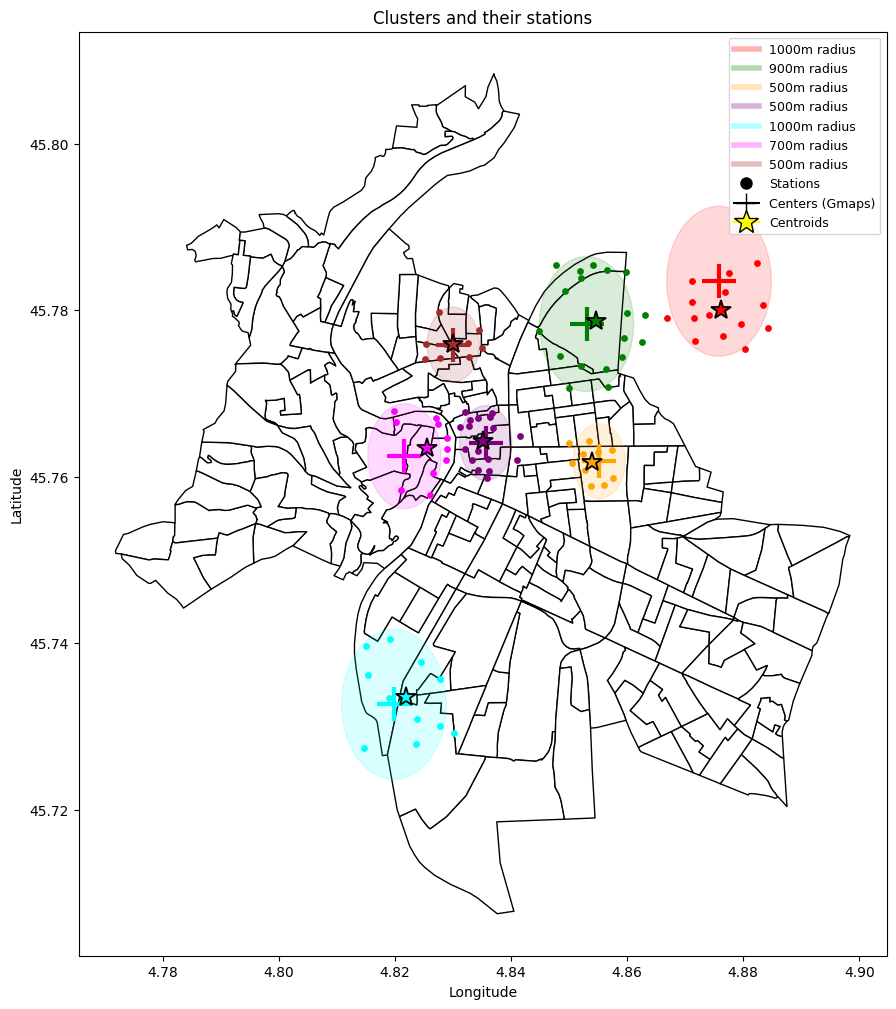

✅ Map with points, centroids, and centers successfully plotted.


In [19]:
# Loading þe shapefile
gdf = gpd.read_file(LYON_IRIS)
gdf.to_crs(epsg=4326, inplace=True)

# Converting gdf_useful in GeoDataFrame of points
gdf_points = gpd.GeoDataFrame(
    gdf_useful,
    geometry=gpd.points_from_xy(gdf_useful.longitude, gdf_useful.latitude),
    crs="EPSG:4326"  # car mes coordonnées sont en lat/lon
)

fig, ax = plt.subplots(figsize=(12, 12))

# Map background
gdf.plot(ax=ax, facecolor="white", edgecolor="black")

legend_handles = []  # to create a proper legend

for place, (lat_c, lon_c) in clusters_centers.items():

    tol    = clusters_radius[place]  # Tolérance en mètres
    color0 = color_map[place]

    # -----------------------------
    # 1/6 Stations proches (points)
    # -----------------------------
    pts = gdf_points[gdf_points[place] == 1].plot(
        ax         = ax,
        color      = color0,
        markersize = size1
    )
    
    # -----------------------------
    # 2/6 Centre exact du lieu (+)
    # -----------------------------
    ax.plot(
        lon_c, lat_c,
        marker     = "+",
        markersize = 25,
        color      = color0,
        mew        = 3
    )

    # -----------------------------
    # 3/6 Centre d’inertie (étoile)
    # -----------------------------
    lat_mean, lon_mean = clusters_centroids[place]
    ax.plot(
        lon_mean, lat_mean,
        marker     = "*",
        markersize = 15,
        color      = color0,
        markeredgecolor = "black",
        markeredgewidth=1.3
    )

    # -----------------------------
    # 4/6 Cercle (buffer de 1 km)
    # -----------------------------
    # Conversion approx. km → degrés (1° lat ≈ 111 km)
    km_to_deg = tol / (111 * 1000)
    circle = plt.Circle(
        (lon_c, lat_c),
        km_to_deg,
        color=color0,
        alpha=0.15,
        edgecolor=color0
    )
    ax.add_patch(circle)

    legend_handles.append(
        plt.Line2D([0], [0], color=color0, lw=4, alpha=0.3,
                    label=f"{tol}m radius")
    )


# -----------------------------
# 5/6 Stations en dehors des clusters (points)
# -----------------------------
if all_stations:
    color0 = color_map['NO_CLUSTER']
    pts = gdf_points[gdf_points['NO_CLUSTER'] == 1].plot(
    ax         = ax,
    color      = color0,
    markersize = size0
    )

# -----------------------------
# 6/6 Éléments pour la légende
# -----------------------------
legend_handles.append(
    plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='black',
                label=f"Stations", markersize=10)
)
legend_handles.append(
    plt.Line2D([0], [0], marker='+', color='black', markersize=15,
                label=f"Centers (Gmaps)")
)
legend_handles.append(
    plt.Line2D([0], [0], marker='*', color='yellow', markeredgecolor='black',
                markersize=18, label=f"Centroids")
)
    
# --- Mise en forme finale ---
plt.title(f"Clusters and their stations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(handles=legend_handles, loc='upper right', fontsize=9)
plt.grid(False)

plt.show()
print("✅ Map with points, centroids, and centers successfully plotted.")

#### **b/ First Multi Linear regression**

##### i ⋅ Adding the clusters columns in the main dataset

- **Adding a cluster name column in `gdf_useful`**

In [61]:
# Number of clusters (based on the length of the cluster centers list)
n_clusters = len(clusters_centers)

# Identify the cluster columns (all columns except the first 3)
# Assuming the actual cluster columns start at index 2 and run for n_clusters columns.
cluster_cols = gdf_useful.columns[3:3+n_clusters+1]

# Create the 'cluster' column by finding the column name that has the value 1 (the one-hot encoded cluster assignment)
gdf_useful['cluster'] = gdf_useful[cluster_cols].idxmax(axis=1)

# The DataFrame gdf_useful now has a 'cluster' column with the assigned cluster name
gdf_useful.head(10)

,idstation,longitude,latitude,LA_DOUA,TETE_D_OR,LA_PART_DIEU,OLD_TOWN,CONFLUENCE,FOURVIERE,CROIX_ROUSSE,NO_CLUSTER,cluster
0,7024,4.840525,45.748520,0,0,0,0,0,0,0,1,NO_CLUSTER
1,10063,4.885609,45.758392,0,0,0,0,0,0,0,1,NO_CLUSTER
2,10021,4.889947,45.759718,0,0,0,0,0,0,0,1,NO_CLUSTER
3,8038,4.867429,45.746716,0,0,0,0,0,0,0,1,NO_CLUSTER
4,7045,4.824488,45.737741,0,0,0,0,1,0,0,0,CONFLUENCE
5,6045,4.857002,45.766367,0,0,0,0,0,0,0,1,NO_CLUSTER
6,8056,4.856813,45.735795,0,0,0,0,0,0,0,1,NO_CLUSTER
7,8015,4.874194,45.740326,0,0,0,0,0,0,0,1,NO_CLUSTER
8,7057,4.835497,45.734725,0,0,0,0,0,0,0,1,NO_CLUSTER
9,7007,4.827719,45.735674,0,0,0,0,1,0,0,0,CONFLUENCE


- **Adding the cluster name column in `gdf_useful`**

In [62]:
# Join df_lyon (the main data frame) with the cluster mapping
df_model2 = df_lyon.merge(
    gdf_useful.drop(columns=['longitude','latitude'], inplace=False).rename(columns={'idstation': 'id_return_station', 'cluster': 'return_cluster'}),
    on='id_return_station',
    how='left'  # Use a left join to keep all rows from the main data frame (df_lyon)
)

df_model2.head(10)

,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,LA_DOUA,TETE_D_OR,LA_PART_DIEU,OLD_TOWN,CONFLUENCE,FOURVIERE,CROIX_ROUSSE,NO_CLUSTER,return_cluster
0,8058,8058 - LONGEFER / KRUGER,2019-04-01 00:00:00+02:00,1022.0,1022 - PLACE TOLOZAN,2019-04-01 00:28:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NO_CLUSTER
1,10103,10103 - DOUA / RUE DES SPORTS,2019-04-01 00:00:00+02:00,6042.0,6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE,2019-04-01 00:07:00+02:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,TETE_D_OR
2,3003,3003 - PART-DIEU / DERUELLE,2019-04-01 00:00:00+02:00,2016.0,2016 - PLACE REGAUD,2019-04-01 00:07:00+02:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,OLD_TOWN
3,6043,6043 - CITÉ INTERNATIONALE / CINÉMA,2019-04-01 00:00:00+02:00,3005.0,3005 - SAXE / GAMBETTA,2019-04-01 00:14:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NO_CLUSTER
4,7033,7033 - SAINT-LUC / SAINT-JOSEPH,2019-04-01 00:01:00+02:00,7053.0,7053 - JAURÈS / THIBAUDIÈRE,2019-04-01 00:05:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NO_CLUSTER
5,2003,2003 - PLACE AMPÈRE,2019-04-01 00:01:00+02:00,2042.0,2042 - JOFFRE / VAUBECOUR,2019-04-01 00:11:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NO_CLUSTER
6,11001,11001 - CALUIRE - GARE DE CUIRE,2019-04-01 00:01:00+02:00,2011.0,2011 - SALA / RUE DU PLAT,2019-04-01 00:13:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NO_CLUSTER
7,10027,10027 - MAIRIE DE VILLEURBANNE,2019-04-01 00:01:00+02:00,2042.0,2042 - JOFFRE / VAUBECOUR,2019-04-01 00:29:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NO_CLUSTER
8,2020,2020 - MUSÉE DES CONFLUENCES,2019-04-01 00:02:00+02:00,2003.0,2003 - PLACE AMPÈRE,2019-04-01 00:13:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NO_CLUSTER
9,3005,3005 - SAXE / GAMBETTA,2019-04-01 00:02:00+02:00,3005.0,3005 - SAXE / GAMBETTA,2019-04-01 00:03:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NO_CLUSTER


- Adding an exit_cluster column then **actually filtering** lines with identincal exit_clust & return_cluster

In [63]:
# Preparing the merge
cluster_mapping_exit = gdf_useful[['idstation', 'cluster']].rename(
    columns={'idstation': 'id_exit_station', 'cluster': 'exit_cluster'}
)

# Merging to easily acces the cluster of the exit station
df_model2 = df_model2.merge(
    cluster_mapping_exit,
    on='id_exit_station',
    how='left'
)
size0, ratio = df_model2.shape[0], 0

# Creating a filter (boolean series) which is True if clusters are different
# !! It's remove all trips outside of clusters !!
condition_different_clusters = (df_model2['exit_cluster'] != df_model2['return_cluster'])

# Applying the filter
df_model2 = df_model2[condition_different_clusters].copy()

# Information on lost trips
print("Number of trip lost : ", size0 - df_model2.shape[0], ", roughly ", 100*(1 - round(df_model2.shape[0]/size0, 2)), "%" )

print(df_model2.head())
# Unused columns
# df_model2 = df_model2.drop(columns=['exit_cluster', 'return_cluster'])

# Memory cleanup
del cluster_mapping_exit, condition_different_clusters

Number of trip lost :  1258725 , roughly  59.00000000000001 %
    id_exit_station                         exit_station  \
1             10103        10103 - DOUA / RUE DES SPORTS   
2              3003          3003 - PART-DIEU / DERUELLE   
3              6043  6043 - CITÉ INTERNATIONALE / CINÉMA   
8              2020         2020 - MUSÉE DES CONFLUENCES   
10             2020         2020 - MUSÉE DES CONFLUENCES   

                   date_exit  id_return_station  \
1  2019-04-01 00:00:00+02:00             6042.0   
2  2019-04-01 00:00:00+02:00             2016.0   
3  2019-04-01 00:00:00+02:00             3005.0   
8  2019-04-01 00:02:00+02:00             2003.0   
10 2019-04-01 00:02:00+02:00             2003.0   

                                      return_station  \
1   6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE   
2                                2016 - PLACE REGAUD   
3                             3005 - SAXE / GAMBETTA   
8                                2003 - PLACE 

( For *Alix*)

In [64]:
df_model2.head()

,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,LA_DOUA,TETE_D_OR,LA_PART_DIEU,OLD_TOWN,CONFLUENCE,FOURVIERE,CROIX_ROUSSE,NO_CLUSTER,return_cluster,exit_cluster
1,10103,10103 - DOUA / RUE DES SPORTS,2019-04-01 00:00:00+02:00,6042.0,6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE,2019-04-01 00:07:00+02:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,TETE_D_OR,LA_DOUA
2,3003,3003 - PART-DIEU / DERUELLE,2019-04-01 00:00:00+02:00,2016.0,2016 - PLACE REGAUD,2019-04-01 00:07:00+02:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,OLD_TOWN,LA_PART_DIEU
3,6043,6043 - CITÉ INTERNATIONALE / CINÉMA,2019-04-01 00:00:00+02:00,3005.0,3005 - SAXE / GAMBETTA,2019-04-01 00:14:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NO_CLUSTER,TETE_D_OR
8,2020,2020 - MUSÉE DES CONFLUENCES,2019-04-01 00:02:00+02:00,2003.0,2003 - PLACE AMPÈRE,2019-04-01 00:13:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NO_CLUSTER,CONFLUENCE
10,2020,2020 - MUSÉE DES CONFLUENCES,2019-04-01 00:02:00+02:00,2003.0,2003 - PLACE AMPÈRE,2019-04-01 00:13:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NO_CLUSTER,CONFLUENCE


In [ ]:
df_model2.drop(colums = ['exit_station','date_exit	'id_return_station	'return_station	'date_return	'LA_DOUA	'TETE_D_OR	'LA_PART_DIEU	'OLD_TOWN	'CONFLUENCE	'FOURVIERE	'CROIX_ROUSSE	'NO_CLUSTER')

##### ii ⋅ Computing the regression

Model 2 completed !


,Coefficient
CONFLUENCE,4.520419
TETE_D_OR,1.496928
LA_DOUA,0.393208
NO_CLUSTER,0.027353
OLD_TOWN,-0.583727
FOURVIERE,-0.655588
LA_PART_DIEU,-2.030784
CROIX_ROUSSE,-3.167808
intercept,12.484805


Validation of Model 2


R²      0.032720
MSE    46.279222
MAE     5.216061
dtype: float64

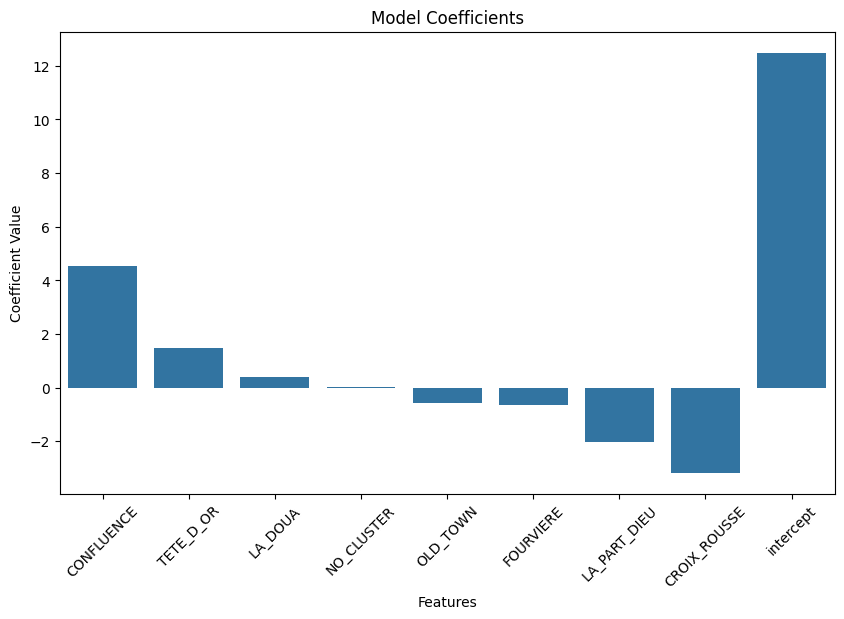

In [24]:
# Creating our multi-linear regression model, predicting the travel time based on the cluster of the return station !

## Splitting our data using my_train_test_split function
y = df_model2['travel_time']

non_x = ['id_exit_station',	'exit_station',	'date_exit', 'id_return_station', 'return_station', 'date_return', 'travel_time', 'distance']
X = df_model2.drop(columns=non_x)
del non_x

X_train, X_test, y_train, y_test = my_train_test_split(X, y)

## Creating model 2
model2 = LinearRegression()
model2.fit(X_train, y_train)

## Retrieval of its coefficient estimates
df_model2_coeffs = build_coeffs_df(model2)

print("Model 2 completed !")
display(df_model2_coeffs)

## Displaying model 2's validation serie
y_pred_model2 = model2.predict(X_test)
s_model2_validation = build_validation_serie(y_test, y_pred_model2)

print("Validation of Model 2")
display(s_model2_validation)

## Plotting a bar plot of the model's coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=df_model2_coeffs.index, y='Coefficient', data=df_model2_coeffs.reset_index())
plt.title('Model Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()

###  <u> **3 - Model 3 // Impact of altitude on the travel time** </u>
We will not compute the D₊ for individual trips, rather aggregate stations into clusters & manually compute the D₊ in between those clusters.

#### a/ First example of clusters definittion

In [12]:
# Define the coordinates of each cluster center
# Picked on Google maps
clusters_centers = {
    'LA_DOUA': (45.783479, 4.875842),
    'TETE_D_OR': (45.778341, 4.853017),
    'LA_PART_DIEU': (45.761882, 4.855204),
    'OLD_TOWN': (45.764043, 4.835659),
    'CONFLUENCE': (45.732634, 4.819839),
    'FOURVIERE': (45.762455, 4.821639),
    'CROIX_ROUSSE': (45.775873,4.830042 )
}

# Define the radius of influence for each cluster in METERS
# Raduis are chosen to have a decent amount of stations 
# In each cluster
clusters_radius = {
    'LA_DOUA': 1000,
    'TETE_D_OR': 900,
    'LA_PART_DIEU': 500,
    'OLD_TOWN': 500,
    'CONFLUENCE': 1000,
    'FOURVIERE': 700,
    'CROIX_ROUSSE': 500
}

# Define the color in which the cluster shall appear on the map
color_map = {
    'LA_DOUA': 'red',
    "TETE_D_OR": 'green',
    'LA_PART_DIEU': 'orange',
    'OLD_TOWN': 'purple',
    'CONFLUENCE': 'cyan',
    'FOURVIERE': 'magenta',
    'CROIX_ROUSSE': 'brown',
    'NO_CLUSTER': 'gray'
}

In [13]:
# Loading station coordinates
gdf_stations = gpd.read_file(BASE_PATH + 'VELO-LYON/locations/pvo_patrimoine_voirie.pvostationvelov.json')
gdf_stations.to_crs(epsg=4326, inplace=True)

# Extracting the longitude & latitude of stations
gdf_stations['longitude'] = gdf_stations.geometry.centroid.x
gdf_stations['latitude'] = gdf_stations.geometry.centroid.y

gdf_stations = gdf_stations[['idstation', 'longitude', 'latitude']]

print("Shape of gdf_stations:", gdf_stations.shape)
gdf_stations.head(5)

Shape of gdf_stations: (431, 3)


/tmp/ipykernel_2196/1008999954.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_stations['longitude'] = gdf_stations.geometry.centroid.x
/tmp/ipykernel_2196/1008999954.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_stations['latitude'] = gdf_stations.geometry.centroid.y


,idstation,longitude,latitude
0,7024,4.840525,45.748520
1,10063,4.885609,45.758392
2,10021,4.889947,45.759718
3,8038,4.867429,45.746716
4,7045,4.824488,45.737741


The distance function

In [14]:
# Function to calculate distance between two geographic points in METERS
def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # Radius of the Earth in kilometers
    dlon = np.radians(lon2 - lon1)
    dlat = np.radians(lat2 - lat1)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c * 1000  # Return distance in METERS

- **Assigning** each station to a cluster by in the colum `cluster`

In [15]:
gdf_useful = gdf_stations
for name, (lat_c, lon_c) in clusters_centers.items():
    distances = haversine(
        gdf_useful['longitude'], gdf_useful['latitude'],
        lon_c, lat_c
    )
    gdf_useful[name] = (distances < clusters_radius[name]).astype(int)

# Creating a column indicating if a station does not belong to any cluster
gdf_useful['NO_CLUSTER'] = (gdf_useful[list(clusters_centers.keys())].sum(axis=1) == 0).astype(int)

print("Number of stations : ", gdf_useful.shape)
# Cleanup
del distances
gdf_useful.head(10)

Number of stations :  (431, 11)


,idstation,longitude,latitude,LA_DOUA,TETE_D_OR,LA_PART_DIEU,OLD_TOWN,CONFLUENCE,FOURVIERE,CROIX_ROUSSE,NO_CLUSTER
0,7024,4.840525,45.748520,0,0,0,0,0,0,0,1
1,10063,4.885609,45.758392,0,0,0,0,0,0,0,1
2,10021,4.889947,45.759718,0,0,0,0,0,0,0,1
3,8038,4.867429,45.746716,0,0,0,0,0,0,0,1
4,7045,4.824488,45.737741,0,0,0,0,1,0,0,0
5,6045,4.857002,45.766367,0,0,0,0,0,0,0,1
6,8056,4.856813,45.735795,0,0,0,0,0,0,0,1
7,8015,4.874194,45.740326,0,0,0,0,0,0,0,1
8,7057,4.835497,45.734725,0,0,0,0,0,0,0,1
9,7007,4.827719,45.735674,0,0,0,0,1,0,0,0


Creating the cluster columns

In [16]:
# Number of clusters (based on the length of the cluster centers list)
n_clusters = len(clusters_centers)

# Identify the cluster columns (all columns except the first 3)
# Assuming the actual cluster columns start at index 2 and run for n_clusters columns.
cluster_cols = gdf_useful.columns[3:3+n_clusters+1]

# Create the 'cluster' column by finding the column name that has the value 1 (the one-hot encoded cluster assignment)
gdf_useful['cluster'] = gdf_useful[cluster_cols].idxmax(axis=1)


# Create the 'cluster' column by finding the column name that has the value 1 (the one-hot encoded cluster assignment)
# gdf_useful['cluster'] = gdf_useful[cluster_cols].idxmax(axis=1)

for i in range(0, gdf_useful.shape[0]):
    if gdf_useful.loc[i,'cluster'] == 'NO_CLUSTER':
        gdf_useful.loc[i,'cluster'] = None

# The DataFrame gdf_useful now has a 'cluster' column with the assigned cluster name
#gdf_useful.head(10)

- **Adding the cluster name column in `gdf_useful`**

In [17]:
# Join df_lyon (the main data frame) with the cluster mapping
df_model3 = df_lyon.merge(
    gdf_useful.drop(columns=['longitude','latitude'], inplace=False).rename(columns={'idstation': 'id_return_station', 'cluster': 'return_cluster'}),
    on='id_return_station',
    how='left'  # Use a left join to keep all rows from the main data frame (df_lyon)
)

#df_model3.head(10)

- Adding an exit_cluster column

In [18]:
# Preparing the merge
cluster_mapping_exit = gdf_useful[['idstation', 'cluster']].rename(
    columns={'idstation': 'id_exit_station', 'cluster': 'exit_cluster'}
)

# Merging to easily acces the cluster of the exit station
df_model3 = df_model3.merge(
    cluster_mapping_exit,
    on='id_exit_station',
    how='left'
)

- Dropping useless columns

In [19]:
df = df_model3.drop(columns=['LA_DOUA', 'TETE_D_OR', 'LA_PART_DIEU', 'OLD_TOWN', 'CONFLUENCE', 'FOURVIERE', 'CROIX_ROUSSE', 'NO_CLUSTER'])
df.head()

,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,travel_time,distance,return_cluster,exit_cluster
0,8058,8058 - LONGEFER / KRUGER,2019-04-01 00:00:00+02:00,1022.0,1022 - PLACE TOLOZAN,2019-04-01 00:28:00+02:00,28.0,4659.845582,None,None
1,10103,10103 - DOUA / RUE DES SPORTS,2019-04-01 00:00:00+02:00,6042.0,6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE,2019-04-01 00:07:00+02:00,7.0,1629.727220,TETE_D_OR,LA_DOUA
2,3003,3003 - PART-DIEU / DERUELLE,2019-04-01 00:00:00+02:00,2016.0,2016 - PLACE REGAUD,2019-04-01 00:07:00+02:00,7.0,1610.518885,OLD_TOWN,LA_PART_DIEU
3,6043,6043 - CITÉ INTERNATIONALE / CINÉMA,2019-04-01 00:00:00+02:00,3005.0,3005 - SAXE / GAMBETTA,2019-04-01 00:14:00+02:00,14.0,3446.325686,None,TETE_D_OR
4,7033,7033 - SAINT-LUC / SAINT-JOSEPH,2019-04-01 00:01:00+02:00,7053.0,7053 - JAURÈS / THIBAUDIÈRE,2019-04-01 00:05:00+02:00,4.0,807.072642,None,None


#### b/ Second example of clusters definition
--> This time, we define them around the stations that have the more trips towards Croix-Rousse